<a href="https://colab.research.google.com/github/manami-bunbun/ES_analysis/blob/main/ES_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第3回 演習（１）Text CNN

CNNは一般的には画像認識の分野で広く使われていますが、自然言語処理のタスクにおいても良い効果を示すことが知られています。

具体的には、RNNに比べて計算の並列化がしやすいために高速であり、時間的に離れた情報間の関係も学習しやすいなどの性質を持ちます。

CNNの入力は、画像認識のタスクにおいては画像のピクセルからなる行列ですが、自然言語処理のタスクにおいては入力は行列で表現された文書や文章になります。

行列の各行は一つのトークン（単語や文字）に対応する特徴ベクトルとなっており、任意のフィルタサイズのカーネルで、行全体をまとめてスライドするように1次元の畳み込みを行います。


今回はText CNNというモデルを使い、CNNで文章のクラス分類を行います。


原論文：[Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)

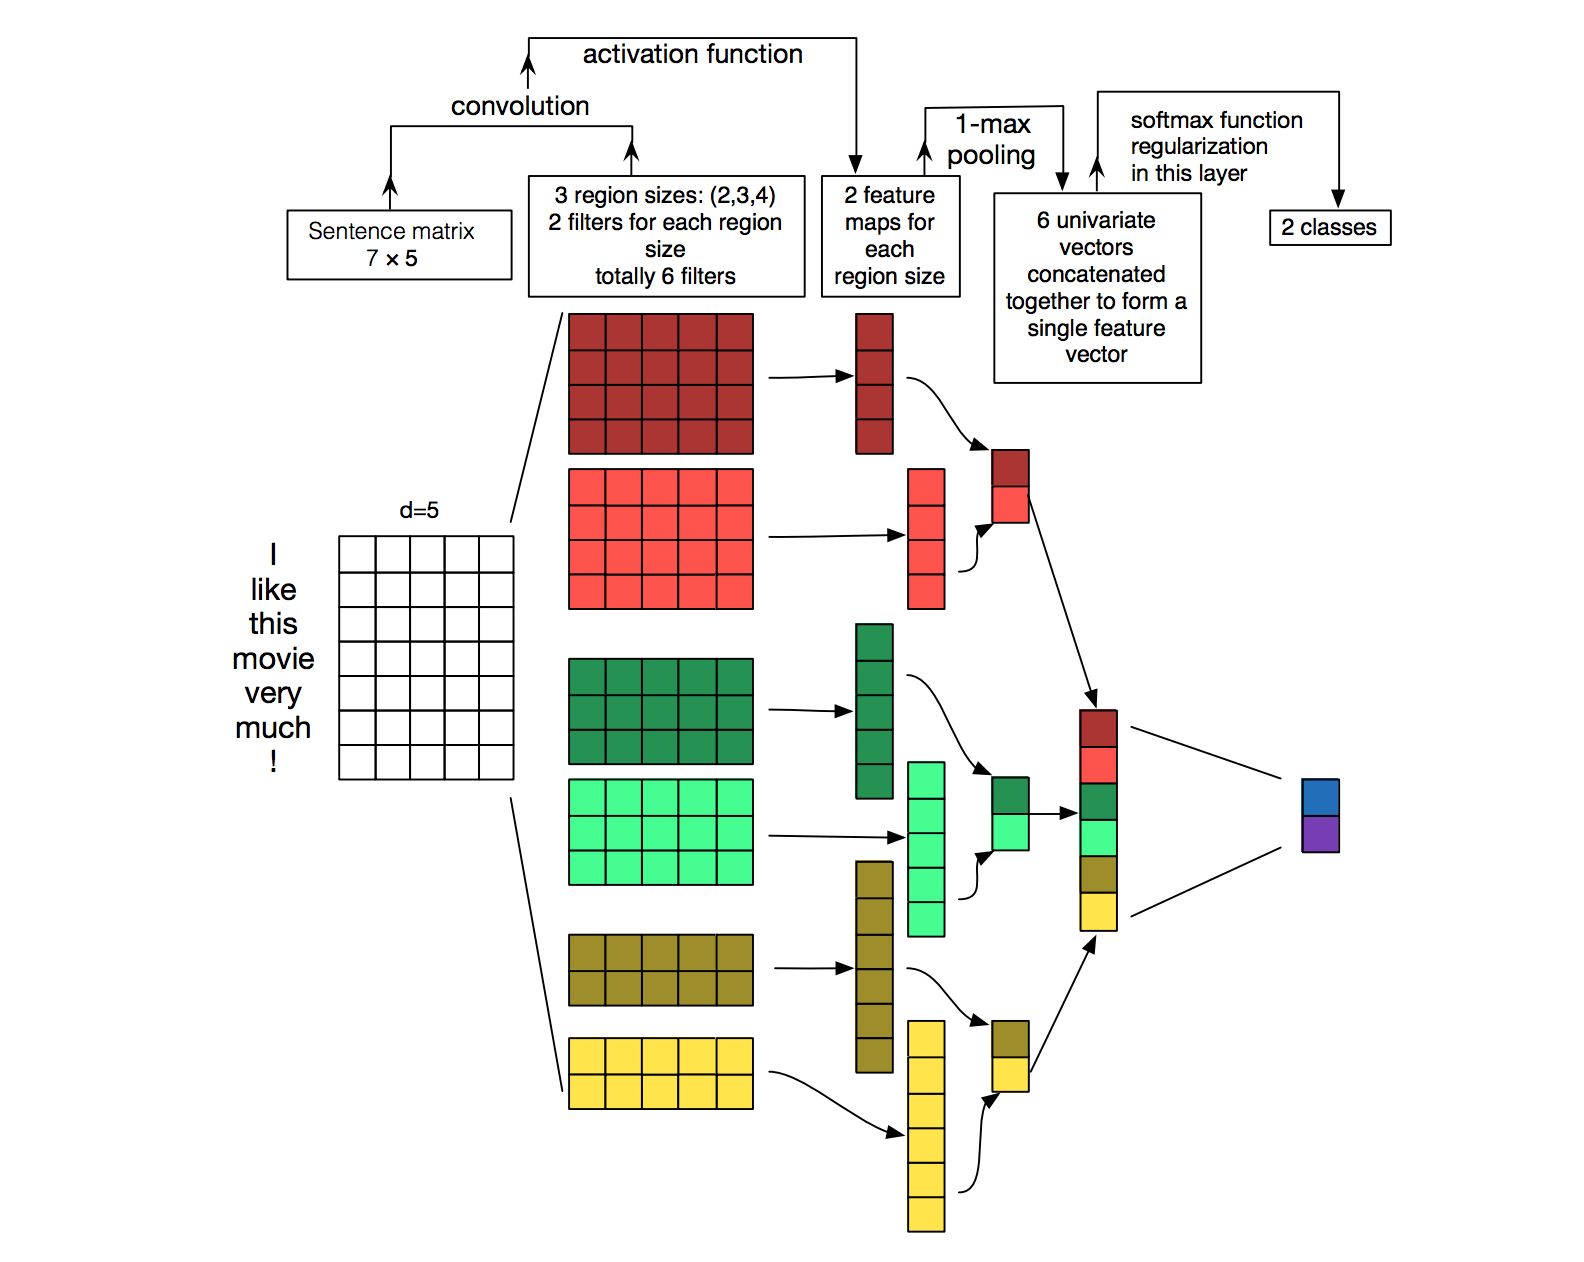

引用元：https://arxiv.org/abs/1510.03820

In [ ]:
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id="17T-RVoVzeoy068m5idXc2AY3BF5xaox2",dest_path="./data.zip", unzip=True)


In [ ]:
class Vocab(object):
    def __init__(self, word2id={}):
        """
        word2id: 単語(str)をインデックス(int)に変換する辞書
        id2word: インデックス(int)を単語(str)に変換する辞書
        """
        self.word2id = dict(word2id)
        self.id2word = {v: k for k, v in self.word2id.items()}    
        
    def build_vocab(self, sentences, min_count=1):
        # 各単語の出現回数の辞書を作成する
        word_counter = {}
        for sentence in sentences:
            for word in sentence:
                word_counter[word] = word_counter.get(word, 0) + 1

        # min_count回以上出現する単語のみ語彙に加える
        for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
            if count < min_count:
                break
            _id = len(self.word2id)
            self.word2id.setdefault(word, _id)
            self.id2word[_id] = word 


In [ ]:
import numpy as np
from sklearn.utils import shuffle
from nltk import Tree

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

特殊なトークンを定義しておきます。

In [ ]:
PAD = 0
UNK = 1

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'

## 1. データセット

今回は、評判分析データセットの1つであるSST（Stanford Sentiment Treebank）と呼ばれるデータセットを用います。

映画レビューサイトのレビューが構文木解析され、文のフレーズごとにポジティブ・ニュートラル・ネガティブのラベルが振られています。

データセットの中身は以下のような構文木になっており、そのままではベクトルに変換できないので、nltkライブラリのTreeを用いてパースします。

In [ ]:
with open('./data/trees/train.txt') as f:
    line = f.readline()
print(line)

tree = Tree.fromstring(line)
print(tree.leaves())

また、各文章には

0: very negative  

1: negative

2: neutral

3: positive

4: very positive

という5つのラベルが振られていますが、今回はタスクを単純にするために

0: negative

1: positive

のラベルのみを振り直し、2クラス分類として定式化します。

In [ ]:
LABEL_DICT = {
    '0': 0,  # very negative -> negative 
    '1': 0,  # negative
    '2': None,  # neutral -> 今回は使わない
    '3': 1,  # positive
    '4': 1,  # ver positive -> positive
}

original_label = tree.label()
print(original_label)

new_label = LABEL_DICT[original_label]
print(new_label)

In [ ]:
def load_data(file_path):
    X = []
    y = []
    with open(file_path) as f:
        for line in f:
            tree = Tree.fromstring(line)  # パース
            x = [word.lower() for word in tree.leaves()]  # ex: ['i', 'have' 'a', 'pen']
            label = LABEL_DICT[tree.label()]  # {0, 1, None}
            if label is None:  # neutralラベルは除外する
                continue
            X.append(x)
            y.append(label)
    return X, y

In [ ]:
# データの読み込み
train_X, train_Y = load_data('./data/trees/train.txt')
valid_X, valid_Y = load_data('./data/trees/dev.txt')
test_X, test_Y = load_data('./data/trees/test.txt')
# 演習用にデータサイズを縮小
train_X = train_X[:len(train_X)//2]
train_Y = train_Y[:len(train_Y)//2]
valid_X = train_X[:len(valid_X)//2]
valid_Y = train_Y[:len(valid_Y)//2]
test_X = train_X[:len(test_X)//2]
test_Y = train_Y[:len(test_Y)//2]
# ラベルを確認
labels = set(train_Y)

In [ ]:
# 語彙の作成
word2id = {
    PAD_TOKEN: PAD,
    UNK_TOKEN: UNK,
    }
vocab = Vocab(word2id=word2id)
vocab.build_vocab(train_X)

In [ ]:
def sentence_to_ids(vocab, sentence):
    """
    単語のリストをIDのリストに変換する
    :param vocab: Vocabのインスタンス
    :param sentence: list of str
    :return indices: list of int
    """
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    return ids

In [ ]:
train_X = [sentence_to_ids(vocab, x) for x in train_X]
valid_X = [sentence_to_ids(vocab, x) for x in valid_X]
test_X = [sentence_to_ids(vocab, x) for x in test_X]

In [ ]:
class DataLoader(object):

    def __init__(self, X, Y, batch_size, shuffle=False):
        """
        :param X: list, 入力言語の文章（単語IDのリスト）のリスト
        :param Y: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(X, Y))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:  # サンプルの順番をシャッフルする
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0  # ポインタの位置を初期化する
    
    def __iter__(self):
        return self

    def __next__(self):
        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得
        X, Y = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        # 短い系列の末尾をパディングする
        lengths_X = [len(s) for s in X]
        max_length_X = max(lengths_X)
        padded_X = [self.pad_seq(s, max_length_X) for s in X]
        # tensorに変換
        batch_X = torch.tensor(padded_X, dtype=torch.long, device=device)
        batch_Y = torch.tensor(Y, dtype=torch.long, device=device)

        # ポインタを更新する
        self.start_index += self.batch_size

        return batch_X, batch_Y
    
    @staticmethod
    def pad_seq(seq, max_length):
        """
        系列の末尾をパディングする
        :param seq: list of int, 単語のインデックスのリスト
        :param max_length: int, バッチ内の系列の最大長
        :return seq: list of int, 単語のインデックスのリスト
        """
        seq += [PAD for i in range(max_length - len(seq))]
        return seq    

## 2. モデルの定義

In [ ]:
class TextCNN(nn.Module):

    def __init__(self, vocab_size, embedding_size, class_num, kernel_num, kernel_sizes, dropout, static):
        """
        :param vocab_size: int, 入力言語の語彙数
        :param embedding_size: int, 埋め込みベクトルの次元数
        :param class_num: int, 出力のクラス数
        :param kernel_num: int,　畳み込み層の出力チャネル数
        :param kernel_sizes: list of int, カーネルのウィンドウサイズ
        :param dropout: float, ドロップアウト率
        :param static: bool, 埋め込みを固定するか否かのフラグ
        """
        super(TextCNN, self).__init__()
        
        self.static = static

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # nn.ModuleList: 任意の数のModuleをlistのような形で保持することが出来るクラス
        self.convs = nn.ModuleList(
            [nn.Conv1d(1, kernel_num, (kernel_size, embedding_size)) for kernel_size in kernel_sizes]
            )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(len(kernel_sizes)*kernel_num, class_num)

    def forward(self, x):
        # x: (batch_size, max_length)
        x = self.embedding(x)  # (batch_size, max_length, embedding_size)
        
        if self.static:
            x = torch.tensor(x)  # 埋め込みを固定

        x = x.unsqueeze(1)  # (batch_size, 1, max_length, embedding_size)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(batch_size, kernel_num, max_length-kernel_size+1), ...]*len(kernel_sizes)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(batch_size, kernel_num), ...]*len(kernel_sizes)

        x = torch.cat(x, 1)  # (batch_size, len(kernel_sizes)*kernel_num)

        x = self.dropout(x)
        logit = self.out(x)  # (batch_size, class_num)
        return logit

## 3. 学習

In [ ]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    # バッチの損失を計算
    model.train(is_train)
    
    if is_train:
        optimizer.zero_grad()
    
    pred_Y = model(batch_X)
    loss = criterion(pred_Y, batch_Y)

    pred = torch.max(pred_Y, 1)[1].view(batch_Y.size())
    n_correct = (pred.data == batch_Y.data).sum()
    
    if is_train:
        loss.backward()
        optimizer.step()

    return loss.item(), n_correct.item()

In [ ]:
model_args = {
    'vocab_size': len(vocab.id2word),
    'embedding_size': 128,
    'class_num': len(labels),
    'kernel_num': 64,
    'kernel_sizes': [3, 4, 5],
    'dropout': 0.5,
    'static': False,
}

lr = 0.001
num_epochs = 30
batch_size = 128
ckpt_path = 'cnn.pth'

In [ ]:
# model
model = TextCNN(**model_args)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_X, train_Y, batch_size)
valid_dataloader = DataLoader(valid_X, valid_Y, batch_size)

In [ ]:
best_valid_acc = 0

for epoch in range(1, num_epochs+1):
    train_losses = []
    train_corrects = 0
    valid_losses = []
    valid_corrects = 0
    # train
    for batch in train_dataloader:
        batch_X, batch_Y = batch
        train_loss, train_correct = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=True
            )
        train_losses.append(train_loss)
        train_corrects += train_correct
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y = batch
        valid_loss, valid_correct = compute_loss(
            batch_X, batch_Y, model, criterion, is_train=False
            )
        valid_losses.append(valid_loss)
        valid_corrects += valid_correct
    train_loss = np.mean(train_losses)
    valid_loss = np.mean(valid_losses)
    train_acc = 100. * train_corrects / len(train_dataloader.data)
    valid_acc = 100. * valid_corrects / len(valid_dataloader.data)
    
    if valid_acc > best_valid_acc:
        ckpt = model.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_acc = valid_acc

    if epoch % 5 == 0:
        print('Epoch {}: train_loss: {:.4f}  train_acc: {:.2f}  valid_loss: {:.4f}  valid_acc: {:.2f}'.format(
                epoch, train_loss, train_acc, valid_loss, valid_acc))
        print('-'*80)


## 4. 評価

In [ ]:
# 学習済みモデルの読み込み
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)
model.eval()

In [ ]:
# テストデータで評価
test_dataloader = DataLoader(test_X, test_Y, batch_size)

test_corrects = 0
for batch in test_dataloader:
    batch_X, batch_Y = batch
    test_loss, test_correct = compute_loss(
        batch_X, batch_Y, model, criterion, is_train=False
        )
    test_corrects += test_correct

test_acc = 100. * test_corrects / len(test_dataloader.data)
print(test_acc)

実際の例を見てみると、正解ラベルが1(positive)である"if you sometimes like to go to the movies to have fun , wasabi is a good place to start ."という文をクラス1と分類できていることがわかります。

In [ ]:
test_dataloader = DataLoader(test_X, test_Y, 1)
x, y  = next(test_dataloader)

pred = model(x).max(1)[1]

x = x.cpu().tolist()[0]
text = ' '.join([vocab.id2word[i] for i in x][:x.index(0)])
print(text)
print('true:', y.item())
print('pred:', pred.item())